In [1]:
'''
This code was adapted from:

@misc{Nain2020,
  author = {Aakash Kumar Nain},
  title = {Cycle{GAN}},
  year = {2020},
  publisher = {GitHub},
  journal = {GitHub repository},
  howpublished = {\url{https://github.com/keras-team/keras-io/blob/master/examples/generative/cyclegan.py},note={Accessed on: 26/05/2023} }

}
'''

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 194-195: truncated \uXXXX escape (1048755434.py, line 13)

In [1]:

import tensorflow as tf
print('TF Version: ', tf.__version__)
from platform import python_version
print('Python Version: ', python_version())

import os
import shutil

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

2023-07-08 15:25:10.303624: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-08 15:25:10.339089: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-08 15:25:10.800111: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


TF Version:  2.12.0
Python Version:  3.10.6


In [2]:
GPU = 3 # define the GPU to use
# Set the GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(GPU)
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

In [3]:


"""
## Setup
"""


import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
#import tensorflow_datasets as tfds
from sklearn.metrics import calinski_harabasz_score

#tfds.disable_progress_bar()
autotune = tf.data.AUTOTUNE


"""
## Prepare the dataset

"""

# Load the horse-zebra dataset using tensorflow-datasets.
#dataset, _ = tfds.load("cycle_gan/horse2zebra", with_info=True, as_supervised=True)
noisy_tr = np.load('hn_train_set.npy')
clean_tr = np.load('ln_train_set.npy')
noisy_va = np.load('hn_valid_set.npy')
clean_va = np.load('ln_valid_set.npy')

noisy_va_sup = np.load('hn_valid_set_sup.npy')
clean_va_sup = np.load('ln_valid_set_sup.npy')

noisy_te = np.load('hn_test_set.npy')
clean_te = np.load('ln_test_set.npy')
#train_noisy, train_clean = np.expand_dims(noisy_tr[:200],axis=0), np.expand_dims(clean_tr[:200],axis=0)
#test_noisy, test_clean = np.expand_dims(noisy_tr[:1],axis=0), np.expand_dims(clean_tr[:1],axis=0)
train_noisy, train_clean = noisy_tr, clean_tr
valid_noisy, valid_clean = noisy_va, clean_va
valid_noisy_sup, valid_clean_sup = noisy_va_sup, clean_va_sup
test_noisy, test_clean = noisy_te, clean_te



input_spec_size = (500,1)
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

buffer_size = 256
batch_size = 5


"""
## Building blocks used in the CycleGAN generators and discriminators
"""


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3),
    strides=(1),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    #x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv1D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(input_tensor)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    #x = ReflectionPadding2D()(x)
    x = layers.Conv1D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3),
    strides=(2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv1D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3),
    strides=(2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv1DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


"""
## Build the generators
"""


def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    spec_input = layers.Input(shape=input_spec_size, name=name + "_spec_input")
    #x = ReflectionPadding2D(padding=(3, 3))(spec_input)
    x = layers.Conv1D(filters, (7), kernel_initializer=kernel_init, use_bias=False,padding="same")(
        spec_input
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    #x = ReflectionPadding2D(padding=(3))(x)
    x = layers.Conv1D(1, (7), padding="same")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(spec_input, x, name=name)
    return model


"""
## Build the discriminators

"""


def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    spec_input = layers.Input(shape=input_spec_size, name=name + "_spec_input")
    x = layers.Conv1D(
        filters,
        (4),
        strides=(2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(spec_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4),
                strides=(2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4),
                strides=(1),
            )

    x = layers.Conv1D(
        1, (4), strides=(1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=spec_input, outputs=x, name=name)
    return model


# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")


"""
## Build the CycleGAN model

We will override the `train_step()` method of the `Model` class
for training via `fit()`.
"""


class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super().__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def call(self, inputs):
        return (
            self.disc_X(inputs),
            self.disc_Y(inputs),
            self.gen_G(inputs),
            self.gen_F(inputs),
        )

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super().compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is noisy and y is clean
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    we can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adverserial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # Horse to fake zebra
            fake_y = self.gen_G(real_x, training=True)
            # Zebra to fake horse -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (Horse to fake zebra to fake horse): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
            "ID_G_loss": id_loss_G,
            "ID_F_loss": id_loss_F,
            "Cycle_G_loss": cycle_loss_G,
            "Cycle_F_loss": cycle_loss_F,
        }


"""
## Create a callback that periodically saves generated images
"""

'''
class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""
    
    def on_epoch_end(self, epoch, logs=None):
        #manually batch test set (200), and evaluate them
        #save noisy network inputs, denoised spectra
        #and ground truths
        spectra = test_noisy
        prediction = np.zeros(np.shape(spectra))
        GTS = np.zeros(np.shape(spectra))
        inputs = np.zeros(np.shape(spectra))
        counter = 0
        for i in range(200, np.shape(spectra)[0], 200):
            prediction[i-200:i,:] = np.squeeze(self.model.gen_G(spectra[i-200:i]))
            GTS[i-200:i,:] = test_clean[i-200:i]
            inputs[i-200:i,:] = spectra[i-200:i]
            counter = counter+1
        # get remaining bit of last batch
        prediction[(200*counter):] = np.squeeze(self.model.gen_G(spectra[(200*counter):]))
        GTS[(200*counter):] = test_clean[(200*counter):]
        inputs[(200*counter):] = spectra[(200*counter):]
        
        prediction = np.reshape(prediction,(-1,500))
        GTS = np.reshape(GTS,(-1,500))
        inputs = np.reshape(inputs,(-1,500))
        path = './epoch_' + str(epoch)
        if os.path.exists(path):
            shutil.rmtree(path)
        os.mkdir(path)
        np.save(path + '/network_denoised', prediction)
        np.save(path + '/network_denoised_GT', GTS)
        np.save(path + '/network_input', inputs)
        
        
        
        # compute supervised validation loss
        spectra_valid = valid_noisy
        prediction_valid = np.zeros(np.shape(spectra_valid))
        GTS_valid = np.zeros(np.shape(spectra_valid))
        inputs_valid = np.zeros(np.shape(spectra_valid))
        
        counter = 0
        for i in range(200, np.shape(spectra_valid)[0], 200):
            prediction_valid[i-200:i,:] = np.squeeze(self.model.gen_G(spectra_valid[i-200:i]))
            GTS_valid[i-200:i,:] = valid_clean[i-200:i]
            inputs_valid[i-200:i,:] = spectra_valid[i-200:i]
            counter = counter+1
        # get remaining bit of last batch
        prediction_valid[(200*counter):] = np.squeeze(self.model.gen_G(spectra_valid[(200*counter):]))
        GTS_valid[(200*counter):] = valid_clean[(200*counter):]
        inputs_valid[(200*counter):] = spectra_valid[(200*counter):]
        
        prediction_valid = np.reshape(prediction_valid,(-1,500))
        GTS_valid = np.reshape(GTS_valid,(-1,500))
        inputs_valid = np.reshape(inputs_valid,(-1,500))
        
        cluster_true = KMeans(8, random_state=4).fit(GTS_valid)
        cluster_pred = cluster_true.predict(prediction_valid)
        
        cluster_true = cluster_true.labels_
        #cluster_pred = cluster_pred.labels_
        valid_loss = metrics.calinski_harabasz_score(prediction_valid, cluster_pred)
        valid_loss_rand = adjusted_rand_score(cluster_true,cluster_pred)
        np.save(path + '/valid_loss_' + str(epoch), valid_loss)
        np.save(path + '/valid_loss_rand_' + str(epoch), valid_loss_rand)
        
        # compute supervised validation loss
        spectra_valid_sup = valid_noisy_sup
        prediction_valid_sup = np.zeros(np.shape(spectra_valid_sup))
        GTS_valid_sup = np.zeros(np.shape(spectra_valid_sup))
        inputs_valid_sup = np.zeros(np.shape(spectra_valid_sup))
        
        counter = 0
        for i in range(200, np.shape(spectra_valid_sup)[0], 200):
            prediction_valid_sup[i-200:i,:] = np.squeeze(self.model.gen_G(spectra_valid_sup[i-200:i]))
            GTS_valid_sup[i-200:i,:] = valid_clean_sup[i-200:i]
            inputs_valid_sup[i-200:i,:] = spectra_valid_sup[i-200:i]
            counter = counter+1
        # get remaining bit of last batch
        prediction_valid_sup[(200*counter):] = np.squeeze(self.model.gen_G(spectra_valid_sup[(200*counter):]))
        GTS_valid_sup[(200*counter):] = valid_clean_sup[(200*counter):]
        inputs_valid_sup[(200*counter):] = spectra_valid_sup[(200*counter):]
        
        prediction_valid_sup = np.reshape(prediction_valid_sup,(-1,500))
        GTS_valid_sup = np.reshape(GTS_valid_sup,(-1,500))
        inputs_valid_sup = np.reshape(inputs_valid_sup,(-1,500))
        
        valid_loss_sup = np.mean(np.mean((np.squeeze(prediction_valid_sup) - np.squeeze(GTS_valid_sup))**2,axis=1))
        
        np.save(path + '/valid_loss_sup_' + str(epoch), valid_loss_sup)
'''
"""
## Train the end-to-end model
"""


# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators


def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.legacy.Adam(learning_rate=2e-5, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.legacy.Adam(learning_rate=2e-5, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.legacy.Adam(learning_rate=2e-5, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.legacy.Adam(learning_rate=2e-5, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)
# Callbacks
#plotter = GANMonitor()
#checkpoint_filepath = "./model_checkpoints/cyclegan_checkpoints.{epoch:03d}"
#model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
#    filepath=checkpoint_filepath, save_weights_only=True
#)



/home/ciaran/.local/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
2023-07-08 15:25:12.324550: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22077 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:bc:00.0, compute capability: 8.9
/home/ciaran/.local/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values 

In [4]:
train_noisy = tf.data.Dataset.from_tensor_slices((train_noisy))
train_clean = tf.data.Dataset.from_tensor_slices((train_clean))
#test_horses = tf.data.Dataset.from_tensor_slices((test_horses))
#test_zebras = tf.data.Dataset.from_tensor_slices((test_zebras))
train_noisy = train_noisy.batch(batch_size)
train_clean = train_clean.batch(batch_size)



#history = cycle_gan_model.fit(
#    tf.data.Dataset.zip((train_noisy, train_clean)),
#    epochs=50,
#    callbacks=[plotter, model_checkpoint_callback],
#)

#np.save('my_history.npy',history.history)

In [5]:


#history=np.load('my_history.npy',allow_pickle='TRUE').item()


In [6]:

# Load the checkpoints
weight_file = "./model_checkpoints/cyclegan_checkpoints.021"
cycle_gan_model.load_weights(weight_file).expect_partial()
print("Weights loaded successfully")



Weights loaded successfully


In [7]:
import scipy.io
mat = scipy.io.loadmat('./Cell_images/Cell_07_In_532.mat')
#mat2 = scipy.io.loadmat('./Cell_images/Cell_07_In_532.mat')
name = mat.keys()
mylist = []
for key in mat.keys():
    mylist.append(key)
name = str(mylist[-1])

In [8]:
a = mat[name][0]
data = a[0][7]
data = data[:,:500]
raw_data = data

reshaped_raw_data = np.reshape(raw_data,(76,84,-1))


In [9]:
for i in range(len(data)):
    data[i] = data[i] - np.min(data[i])
norm_fact = np.max(data)/2
data = data/norm_fact

In [10]:
denoised = []
for i in range(len(data)):
    #print(i)
    denoised.append(cycle_gan_model.gen_G(np.expand_dims(data[i],axis=0)))

2023-07-08 15:25:14.893675: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


In [11]:
denoised = np.squeeze(denoised)

In [12]:
reshaped_denoised = np.reshape(denoised,(76,84,-1))

In [13]:
import scipy.io
mat = scipy.io.loadmat('./Cell_images/Cell_07_Out_532.mat')
#mat2 = scipy.io.loadmat('./Cell_images/Cell_07_In_532.mat')
name = mat.keys()
mylist = []
for key in mat.keys():
    mylist.append(key)
name = str(mylist[-1])

In [14]:
a = mat[name][0]
data_gt = a[0][7]
data_gt = data_gt[:,:500]


In [15]:
with open('axis.txt') as file:
    wavenumbers = [float(line.rstrip()) for line in file]

In [79]:
ind = np.where(np.round(wavenumbers) == 1450)

In [80]:
ind = int(ind[0])

In [63]:
print(np.round(wavenumbers))

[ 498.  501.  504.  507.  510.  512.  515.  518.  521.  524.  526.  529.
  532.  535.  538.  540.  543.  546.  549.  552.  555.  557.  560.  563.
  566.  569.  571.  574.  577.  580.  583.  585.  588.  591.  594.  596.
  599.  602.  605.  608.  610.  613.  616.  619.  622.  624.  627.  630.
  633.  635.  638.  641.  644.  647.  649.  652.  655.  658.  660.  663.
  666.  669.  671.  674.  677.  680.  683.  685.  688.  691.  694.  696.
  699.  702.  705.  707.  710.  713.  716.  718.  721.  724.  727.  729.
  732.  735.  738.  740.  743.  746.  749.  751.  754.  757.  759.  762.
  765.  768.  770.  773.  776.  779.  781.  784.  787.  790.  792.  795.
  798.  800.  803.  806.  809.  811.  814.  817.  820.  822.  825.  828.
  830.  833.  836.  839.  841.  844.  847.  849.  852.  855.  857.  860.
  863.  866.  868.  871.  874.  876.  879.  882.  884.  887.  890.  893.
  895.  898.  901.  903.  906.  909.  911.  914.  917.  919.  922.  925.
  928.  930.  933.  936.  938.  941.  944.  946.  9

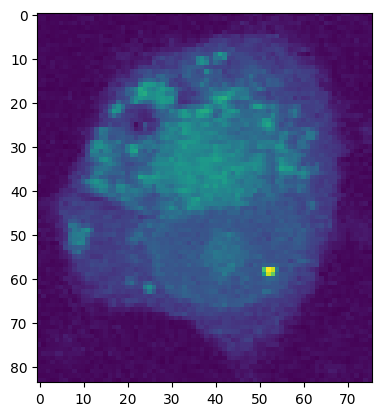

In [18]:
plt.imshow(reshaped_denoised[:,:,ind].T)

In [19]:
from skimage.restoration import denoise_wavelet
spec_denoise_w = []
for i in range(len(data)):
    spec_denoise_w.append(denoise_wavelet(data[i], method='BayesShrink', mode='soft', wavelet_levels=9, wavelet='sym8', rescale_sigma='True'))

/home/ciaran/.local/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  warnings.warn(


In [20]:
np.shape(spec_denoise_w)

(6384, 500)

In [21]:
from BaselineRemoval import BaselineRemoval
smoothed_spectra = spec_denoise_w
wav_spectra = []
for i in range(np.shape(spec_denoise_w)[0]):
    # adding a small constant to enable baseline correction
    smoothed_spectra[i][np.where(smoothed_spectra[i]==0)]=0.0001
    #print(np.shape(smoothed_spectra[i]))
    baseObj=BaselineRemoval(smoothed_spectra[i])
    mod=baseObj.ModPoly(3)
    smoothed_spectra[i]=mod/np.max(mod)
        
wav_spectra = smoothed_spectra
reshaped_wav_spectra = np.reshape(wav_spectra,(76,84,-1))
np.save('./Cell_images/wav_spectra.npy',wav_spectra)
np.save('./Cell_images/reshaped_wav_spectra.npy',reshaped_wav_spectra)

In [22]:
smoothed_spectra = denoised
cycle_spectra = []
for i in range(np.shape(denoised)[0]):
    # adding a small constant to enable baseline correction
    smoothed_spectra[i][np.where(smoothed_spectra[i]==0)]=0.0001
    
    baseObj=BaselineRemoval(smoothed_spectra[i])
    mod=baseObj.ModPoly(3)
    smoothed_spectra[i]=mod/np.max(mod)
        
cycle_spectra = smoothed_spectra
reshaped_cycle_spectra = np.reshape(cycle_spectra,(76,84,-1))
np.save('./Cell_images/cycle_spectra.npy',cycle_spectra)
np.save('./Cell_images/reshaped_cycle_spectra.npy',reshaped_cycle_spectra)

In [23]:
smoothed_spectra = data_gt
gt_spectra = []
for i in range(np.shape(data_gt)[0]):
    # adding a small constant to enable baseline correction
    smoothed_spectra[i][np.where(smoothed_spectra[i]==0)]=0.0001

    baseObj=BaselineRemoval(smoothed_spectra[i])
    mod=baseObj.ModPoly(3)
    smoothed_spectra[i]=mod/np.max(mod)
        
gt_spectra = smoothed_spectra
reshaped_gt_spectra = np.reshape(gt_spectra,(76,84,-1))
np.save('./Cell_images/gt_spectra.npy',gt_spectra)
np.save('./Cell_images/reshaped_gt_spectra.npy',reshaped_gt_spectra)

In [31]:
smoothed_spectra = raw_data
inp_spectra = []
for i in range(np.shape(raw_data)[0]):
    # adding a small constant to enable baseline correction
    smoothed_spectra[i][np.where(smoothed_spectra[i]==0)]=0.0001

    baseObj=BaselineRemoval(smoothed_spectra[i])
    mod=baseObj.ModPoly(3)
    smoothed_spectra[i]=mod/np.max(mod)
        
inp_spectra = smoothed_spectra
reshaped_inp_spectra = np.reshape(inp_spectra,(76,84,-1))
np.save('./Cell_images/inp_spectra.npy',inp_spectra)
np.save('./Cell_images/reshaped_inp_spectra.npy',reshaped_inp_spectra)

Text(0.5, 1.0, 'Noisy HSI 1450 cm-1')

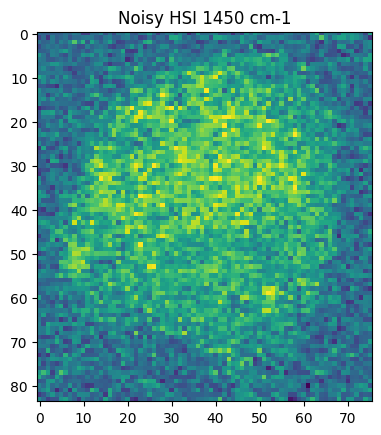

In [105]:
plt.imshow(reshaped_inp_spectra[:,:,ind].T)
plt.title('Noisy HSI 1450 cm-1')

Text(0.5, 1.0, 'High SNR HSI 1450 cm-1')

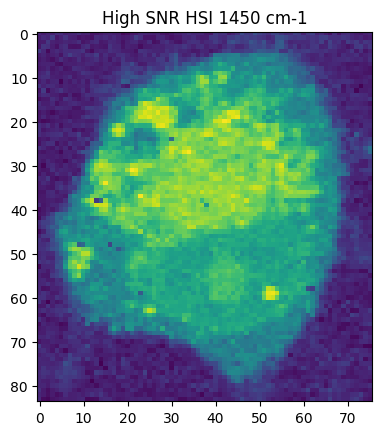

In [104]:
plt.imshow(reshaped_gt_spectra[:,:,ind].T)
plt.title('High SNR HSI 1450 cm-1')

Text(0.5, 1.0, 'Cycle denoised HSI 1450 cm-1')

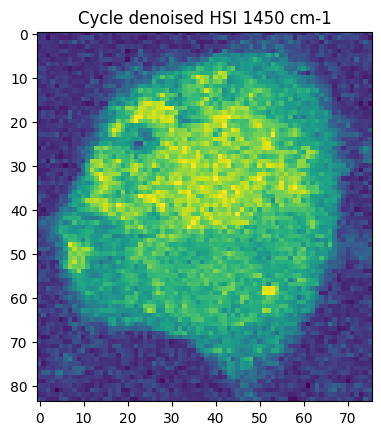

In [103]:
plt.imshow(reshaped_cycle_spectra[:,:,ind].T)
plt.title('Cycle denoised HSI 1450 cm-1')

Text(0.5, 1.0, 'Wavelet denoised HSI 1450 cm-1')

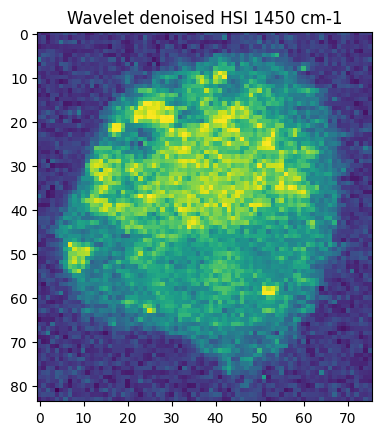

In [102]:
plt.imshow(reshaped_wav_spectra[:,:,ind].T)
plt.title('Wavelet denoised HSI 1450 cm-1')

In [85]:
print(np.max(data))

1.0


In [86]:
np.mean(np.mean((cycle_spectra-gt_spectra)**2,axis=1))

0.004413158

In [87]:
np.mean(np.mean((wav_spectra-gt_spectra)**2,axis=1))

0.008187168661242469

Text(0.5, 1.0, 'Cyto')

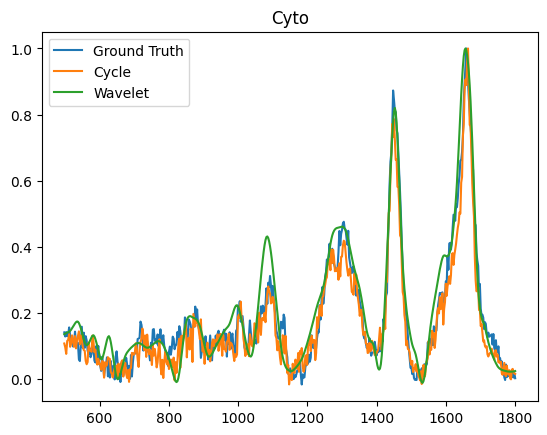

In [106]:
plt.plot(wavenumbers, reshaped_gt_spectra[50,25,:],label = 'Ground Truth')
plt.plot(wavenumbers, reshaped_cycle_spectra[50,25,:],label = 'Cycle')
plt.plot(wavenumbers, reshaped_wav_spectra[50,25,:],label = 'Wavelet')
plt.legend()
plt.title('Cyto')

Text(0.5, 1.0, 'Nucleic')

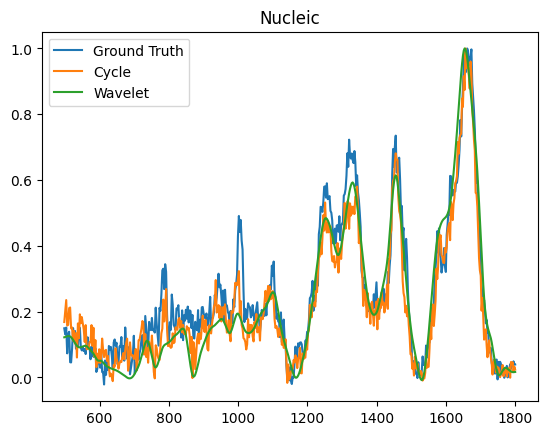

In [107]:
plt.plot(wavenumbers, reshaped_gt_spectra[43,60,:],label = 'Ground Truth')
plt.plot(wavenumbers, reshaped_cycle_spectra[43,60,:],label = 'Cycle')
plt.plot(wavenumbers, reshaped_wav_spectra[43,60,:],label = 'Wavelet')
plt.legend()
plt.title('Nucleic')